This notebook focuses on sentiment analysis task using two types of deep neural network, namely RNNs and CNNs and compare the results. 

The Amazon review dataset (https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews) is used in this TMA for sentiment analysis. The pre-processed dataset can be found in the directory /datasets/amazon-reviews/, divided into training, validation and test sets. The dataset has been adapted so that there is a rating of 0=negative and 1=positive for each review document.


## Taking a section of the training dataset

## Importing the required libraries - Provided by the OU

In [1]:
import numpy as np
import tensorflow as tf
import json
import scipy

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets, metrics, Sequential, utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

from tensorflow.keras.layers import Dense, Embedding, LSTM


## Creating some constants

In [2]:
BATCH_SIZE = 512

In [3]:
METRICS = [
      lambda : tf.keras.metrics.TruePositives(name='tp'),
      lambda : tf.keras.metrics.FalsePositives(name='fp'),
      lambda : tf.keras.metrics.TrueNegatives(name='tn'),
      lambda : tf.keras.metrics.FalseNegatives(name='fn'), 

      lambda : tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      lambda : tf.keras.metrics.Precision(name='precision'),
      lambda : tf.keras.metrics.Recall(name='recall'),
]

def fresh_metrics():
    return [metric() for metric in METRICS]

## Loading the data

In [4]:
train_filename = '/datasets/amazon-reviews/train.csv'
val_filename = '/datasets/amazon-reviews/validation.csv'
test_filename = '/datasets/amazon-reviews/test.csv'

In [5]:
train_data = tf.data.experimental.make_csv_dataset(train_filename, batch_size=BATCH_SIZE, num_epochs=1)
train_data = train_data.map(lambda d: (d['Review'], d['Rating']))

In [6]:
# take 10% of the training data
train_data10 = train_data.shard(10, 0)

train_data10 = train_data10.cache()
train_data10 = train_data10.shuffle(50000)
train_data10 = train_data10.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [7]:
# take 25% of the training data
train_data25 = train_data.shard(4, 0)

train_data25 = train_data25.cache()
train_data25 = train_data25.shuffle(50000)
train_data25 = train_data25.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [8]:
# take 50% of the training data
train_data50 = train_data.shard(2, 0)

train_data50 = train_data50.cache()
train_data50 = train_data50.shuffle(50000)
train_data50 = train_data50.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [9]:
# use all the training data
train_data = train_data.cache()
train_data = train_data.shuffle(50000)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [10]:
validation_data = tf.data.experimental.make_csv_dataset(val_filename, batch_size=BATCH_SIZE, num_epochs=1)
validation_data = validation_data.map(lambda d: (d['Review'], d['Rating']))
validation_data = validation_data.cache()
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [11]:
test_data = tf.data.experimental.make_csv_dataset(test_filename, batch_size=BATCH_SIZE, num_epochs=1)
test_data = test_data.map(lambda d: (d['Review'], d['Rating']))
test_data = test_data.cache()
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating encoders - Provided by the OU

The following code creates and saves text encoders for different vocabulary sizes. Running this code will take some time, but this saves the files for use later.

After your first run of this notebook, you can comment out the cells that adapt and save the encoders.

In [34]:
!mkdir encoder100
!mkdir encoder200
!mkdir encoder300

mkdir: cannot create directory ‘encoder100’: File exists
mkdir: cannot create directory ‘encoder200’: File exists
mkdir: cannot create directory ‘encoder300’: File exists


### Create, adapt, and save an encoder

You will only need to do this once. You may like to comment out the code in these cells after the first run.

In [13]:
encoder = tf.keras.layers.TextVectorization(max_tokens=100)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder100')

In [14]:
encoder = tf.keras.layers.TextVectorization(max_tokens=200)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder200')

In [15]:
encoder = tf.keras.layers.TextVectorization(max_tokens=300)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder300')

### Create an encoder and load its assets from file

In [12]:
encoder100 = tf.keras.layers.TextVectorization(output_sequence_length=100,max_tokens=100)
encoder100.load_assets('encoder100')

In [13]:
encoder200 = tf.keras.layers.TextVectorization(output_sequence_length=100,max_tokens=200)
encoder200.load_assets('encoder200')

In [14]:
encoder300 = tf.keras.layers.TextVectorization(output_sequence_length=100,max_tokens=300)
encoder300.load_assets('encoder300')

3 CNN models:

* CNN_model_1: using 200-word encoder, word embedding length of 16, with a 1D convolution layer (32 filters, kernel size of 5)
* CNN_model_2: using 300-word encoder, word embedding length of 16, with a 1D convolution layer (32 filters, kernel size of 5)
* CNN_model_3: using 300-word encoder, word embedding length of 16, with a 1D convolution layer (64 filters, kernel size of 3)

* For all the above models, the final 1D CNN layer is followed by a max-pooling layer, a dense layer of 64 nodes (activation function relu), and a dense layer of one node (with sigmoid activation) for final classification.




## Build the required models

In [ ]:

# Build the models
EMBEDDING_LEN = 16  # The length of the word embedding vector for all three models
KERNEL_SIZE = 5 # Kernel size for first 2 models
KERNEL_SIZE_3 = 3 # Kernel size for 3rd model

# CNN_model_1
# 200-word encoder
# Word embedding length of 16
# 1D convolution layer with 32 filters and kernel size of 5
# Max pooling layer
# 2 Dense layers, 1 with 64 nodes and 'relu', 1 with 1 node and 'sigmoid')
CNN_model_1 = Sequential([
    encoder200,
    Embedding(input_dim=len(encoder200.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Conv1D(filters=32, kernel_size=KERNEL_SIZE, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# CNN_model_2
# 300-word encoder
# Word embedding length of 16
# 1D convolution layer with 32 filters and kernel size of 5
# Max pooling layer
# 2 Dense layers, 1 with 64 nodes and 'relu', 1 with 1 node and 'sigmoid')
CNN_model_2= Sequential([
    encoder300,
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Conv1D(filters=32, kernel_size=KERNEL_SIZE, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# CNN_model_3
# 300-word encoder
# Word embedding length of 16
# 1D convolution layer with 64 filters and kernel size of 3
# Max pooling layer
# 2 Dense layers, 1 with 64 nodes and 'relu', 1 with 1 node and 'sigmoid')
CNN_model_3= Sequential([
    encoder300,
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE_3, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

Train the models, show their structures and parameters, and produce training and validation curves

In [83]:
# Compile the models
# CNN_model_1
CNN_model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# CNN_model_2
CNN_model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# CNN_model_3
CNN_model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the models
# CNN_model_1
CNN_model_1_history = CNN_model_1.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

# CNN_model_2
CNN_model_2_history = CNN_model_2.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

# CNN_model_3
CNN_model_3_history = CNN_model_3.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

# Save the trained models and training history

# CNN_model_1
CNN_model_1.save('CNN_model_1_review.keras')
with open('CNN_model_1_review_history.json', 'w') as f:
    json.dump(CNN_model_1_history.history, f)

# CNN_model_2
CNN_model_2.save('CNN_model_2_review.keras')
with open('CNN_model_2_review_history.json', 'w') as f:
    json.dump(CNN_model_2_history.history, f)

# CNN_model_3
CNN_model_3.save('CNN_model_3_review.keras')
with open('CNN_model_3_review_history.json', 'w') as f:
    json.dump(CNN_model_3_history.history, f)
    

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d_42' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6930 - loss: 0.5594 - val_accuracy: 0.7835 - val_loss: 0.4517
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7863 - loss: 0.4482 - val_accuracy: 0.7948 - val_loss: 0.4327
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7977 - loss: 0.4302 - val_accuracy: 0.7946 - val_loss: 0.4327
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8049 - loss: 0.4200 - val_accuracy: 0.8015 - val_loss: 0.4209
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8082 - loss: 0.4133 - val_accuracy: 0.8042 - val_loss: 0.4172
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d_43' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7086 - loss: 0.5379 - val_accuracy: 0.8068 - val_loss: 0.4118
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8122 - loss: 0.4077 - val_accuracy: 0.8143 - val_loss: 0.3999
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8228 - loss: 0.3883 - val_accuracy: 0.8238 - val_loss: 0.3836
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8278 - loss: 0.3769 - val_accuracy: 0.8264 - val_loss: 0.3796
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8321 - loss: 0.3706 - val_accuracy: 0.8275 - val_loss: 0.3769
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d_44' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7141 - loss: 0.5310 - val_accuracy: 0.8070 - val_loss: 0.4103
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8133 - loss: 0.4033 - val_accuracy: 0.8193 - val_loss: 0.3912
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8238 - loss: 0.3865 - val_accuracy: 0.8260 - val_loss: 0.3824
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8296 - loss: 0.3756 - val_accuracy: 0.8277 - val_loss: 0.3779
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8342 - loss: 0.3685 - val_accuracy: 0.8267 - val_loss: 0.3790


In [84]:
# Reload the models and training historys
# CNN_model_1
CNN_model_1 = tf.keras.models.load_model('CNN_model_1_review.keras')
with open('CNN_model_1_review_history.json') as f:
    CNN_model_1_history = json.load(f)

# CNN_model_2
CNN_model_2 = tf.keras.models.load_model('CNN_model_2_review.keras')
with open('CNN_model_2_review_history.json') as f:
    CNN_model_2_history = json.load(f)

# CNN_model_3
CNN_model_3 = tf.keras.models.load_model('CNN_model_3_review.keras')
with open('CNN_model_3_review_history.json') as f:
    CNN_model_3_history = json.load(f)

In [85]:
# put your code here
# Print a summary of the 3 models

# CNN_model_1
CNN_model_1.summary()

# CNN_model_2
CNN_model_2.summary()

# CNN_model_3
CNN_model_3.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_20 (Embedding)        │ (None, 100, 16)        │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 100, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_19         │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,909 (93.40 KB)

 Trainable params: 7,969 (31.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,940 (62.27 KB)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_21 (Embedding)        │ (None, 100, 16)        │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 100, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_20         │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,709 (112.15 KB)

 Trainable params: 9,569 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,140 (74.77 KB)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_22 (Embedding)        │ (None, 100, 16)        │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 100, 64)        │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_21         │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,485 (142.52 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,324 (95.02 KB)

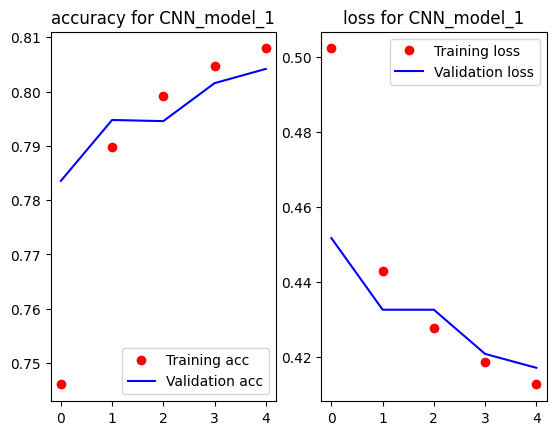

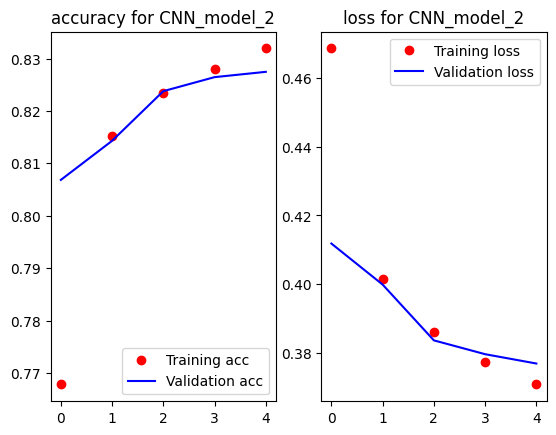

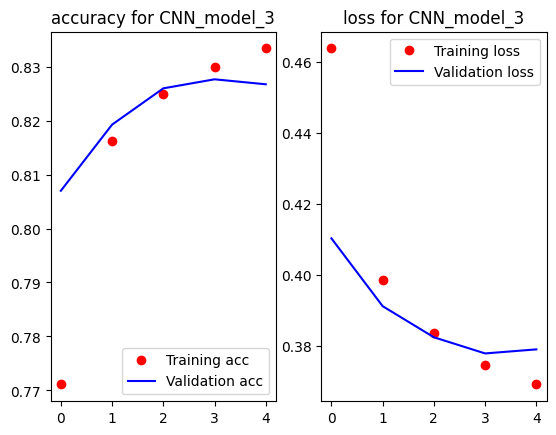

In [91]:
# plot the three models training and validation graphs
# CNN_model_1
acc = CNN_model_1_history['accuracy']
val_acc = CNN_model_1_history['val_accuracy']
loss = CNN_model_1_history['loss']
val_loss = CNN_model_1_history['val_loss']

epochs = range(len(acc))

plt.subplot(1,2,1)

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('accuracy for CNN_model_1')
plt.legend()

plt.subplot(1,2,2)


plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('loss for CNN_model_1')
plt.legend()

plt.show()

# CNN_model_2
acc = CNN_model_2_history['accuracy']
val_acc = CNN_model_2_history['val_accuracy']
loss = CNN_model_2_history['loss']
val_loss = CNN_model_2_history['val_loss']

plt.subplot(1,2,1)

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('accuracy for CNN_model_2')
plt.legend()

plt.subplot(1,2,2)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('loss for CNN_model_2')
plt.legend()

plt.show()

# CNN_model_3
acc = CNN_model_3_history['accuracy']
val_acc = CNN_model_3_history['val_accuracy']
loss = CNN_model_3_history['loss']
val_loss = CNN_model_3_history['val_loss']

plt.subplot(1,2,1)

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('accuracy for CNN_model_3')
plt.legend()

plt.subplot(1,2,2)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('loss for CNN_model_3')
plt.legend()

plt.show()


## Evaluate the trained models on the test data

In [87]:
# put your code here
# Evaluate CNN_model_1
CNN_model_1.evaluate(test_data, return_dict = True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8027 - loss: 0.4222


{'accuracy': 0.8028500080108643, 'loss': 0.4204852283000946}

In [88]:
# Evaluate CNN_model_2
CNN_model_2.evaluate(test_data, return_dict = True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8274 - loss: 0.3810


{'accuracy': 0.8277562260627747, 'loss': 0.3802325129508972}

In [89]:
# Evaluate CNN_model_3
CNN_model_3.evaluate(test_data, return_dict = True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8260 - loss: 0.3812


{'accuracy': 0.8260343670845032, 'loss': 0.38043421506881714}

## Compare and comment on the results

> Put your answer here
>
> CNN_model_1 is the least effective model. It has the lowest accuracy of 0.80 and the highest loss of 0.43.
>
> Having said that, CNN_model_2 and CNN_model_3 are not significantly better. They both have an accuracy of 0.83, which is only an increase of 0.03 and a loss of 0.38, a decrease of 0.05 from CNN_model_1.
>
> From the training and validation graphs, we can also see that CNN_model_3 may be starting to show signs of over-fitting as the validation line is starting to move further away from the training dots.
>
> The graphs also suggest that CNN_model_2 may benefit from more training and a larger number of epochs. This is because of how steep the gradient is on the validation graph, suggesting if the model continues on a similar trend, it will better its 0.83 accuracy and 0.38 loss.
>
> This suggests that increasing the size of the word encoder from 200 to 300 and increasing the vocab size can improve a model performance. This is expected as there will be less 'out of vocabulary' (OOV) words that the model wont be able to understand.
>
> The lack of improvement from CNN_model_2 to CNN_model_3 may suggest that increasing the filters in the convolutional layer from 32 to 64 does little to improve the model. However, it was able to achieve this with a smaller kernel size of 3, compared with CNN_model_2's kernel size of 5. Meaning it was able to achieve the same results with less input information. A smaller Kernel size can be very desirable as they use fewer parameters and computations.
>
> As a result CNN_model_3 is the best performing model, as, while it achieves the same accuracy (0.83) and loss(0.38) as CNN_model_2, it does so by doing less work, through its smaller kernel size.
> 

## Model 4 Changes
>
> Word Embedding length to 64. It is still a somewhat small dataset, so larger than 64 is not necessary but 64 should be sufficient to see an increase in performance while not wasting resources.
>
> Two extra CNN layers with 64 filters and 3 kernel size. More CNN layers help to extract more complex features from the data.
>
> Adding CNN layers adds complexity to the model, the more complex a model, the more chance there is of over-fitting. A low probability dropout layer introduced of rate of 0.1 will reduce the chances of the model over-fitting.

In [ ]:

# model 4

# Change 1
# Word embedding length of 64
EMBEDDING_LEN = 64

# 1D CNN layer with 64 filters and Kernel size of 3

# CHANGE 2
# Second 1D convolution layer 
# with 64 filters

# kernel size of 3
KERNEL_SIZE_3 = 3

# CHANGE 3
# Dropout layer

# Max pooling layer
# 2 Dense layers, 1 with 64 nodes and 'relu', 1 with 1 node and 'sigmoid')
CNN_model_4= Sequential([
    encoder300,
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE_3, padding='same', activation='relu'),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE_3, padding='same', activation='relu'),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE_3, padding='same', activation='relu'),
    Dropout(rate=0.1),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model CNN_model_4
CNN_model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# Train model CNN_model_4
CNN_model_4_history = CNN_model_4.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d_37' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.7300 - loss: 0.5068 - val_accuracy: 0.8227 - val_loss: 0.3888
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8247 - loss: 0.3822 - val_accuracy: 0.8362 - val_loss: 0.3637
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8374 - loss: 0.3606 - val_accuracy: 0.8430 - val_loss: 0.3521
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8476 - loss: 0.3427 - val_accuracy: 0.8460 - val_loss: 0.3452
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8537 - loss: 0.3321 - val_accuracy: 0.8471 - val_loss: 0.3423


## Model 5
>
> Vocab size increased to 1000. This would reduce the number of Out-Of-Vocabulary (OOV) words and allow the model to understand more of the data. 
>
> An increased Kernel size will allow to model to capture more localized features. Kernel size increased from 3 to 5.

In [ ]:
# Add new encoder with 1000 words
!mkdir encoder1000

In [ ]:
# Create, save and adapt encoder with 1000 words
encoder = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder1000')

In [37]:
# put your code here
# model 5

# CHANGE 1
# Vocab size increased to 1000


# Word embedding length of 64
EMBEDDING_LEN = 64

# Increase vocab size
encoder1000 = tf.keras.layers.TextVectorization(output_sequence_length=100,max_tokens=1000)
encoder1000.load_assets('encoder1000')

# Second and third 1D convolution layer 
# with 64 filters each

# CHANGE 2
# kernel size of 5
KERNEL_SIZE_5 = 5

# Dropout layer

# Max pooling layer
# 2 Dense layers, 1 with 64 nodes and 'relu', 1 with 1 node and 'sigmoid')
CNN_model_5= Sequential([
    encoder1000,
    Embedding(input_dim=len(encoder1000.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE_5, padding='same', activation='relu'),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE_5, padding='same', activation='relu'),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE_5, padding='same', activation='relu'),
    Dropout(rate=0.1),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model CNN_model_5
CNN_model_5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# Train model CNN_model_5
CNN_model_5_history = CNN_model_5.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d_34' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.7618 - loss: 0.4521 - val_accuracy: 0.8679 - val_loss: 0.3054
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8719 - loss: 0.2955 - val_accuracy: 0.8782 - val_loss: 0.2858
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8863 - loss: 0.2698 - val_accuracy: 0.8867 - val_loss: 0.2693
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8980 - loss: 0.2468 - val_accuracy: 0.8893 - val_loss: 0.2645
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9057 - loss: 0.2311 - val_accuracy: 0.8894 - val_loss: 0.2623


In [40]:
# Save the trained models and training history

# CNN_model_4
CNN_model_4.save('CNN_model_4_review.keras')
with open('CNN_model_4_review_history.json', 'w') as f:
    json.dump(CNN_model_4_history.history, f)

# CNN_model_5
CNN_model_5.save('CNN_model_5_review.keras')
with open('CNN_model_5_review_history.json', 'w') as f:
    json.dump(CNN_model_5_history.history, f)

## Train the extended models, show their structures and parameters, and produce training and validation curves

In [41]:
# Reload the models and training data
# CNN_model_4
CNN_model_4 = tf.keras.models.load_model('CNN_model_4_review.keras')
with open('CNN_model_4_review_history.json') as f:
    CNN_model_4_history = json.load(f)

# CNN_model_5
CNN_model_5 = tf.keras.models.load_model('CNN_model_5_review.keras')
with open('CNN_model_5_review_history.json') as f:
    CNN_model_5_history = json.load(f)

In [42]:
# put your code here
CNN_model_4.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_13 (Embedding)        │ (None, 100, 64)        │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 100, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 100, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 100, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,445 (708.77 KB)

 Trainable params: 60,481 (236.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 120,964 (472.52 KB)

<Figure size 640x480 with 0 Axes>

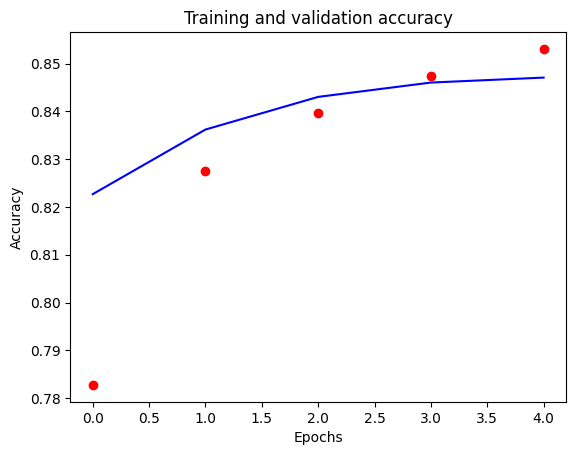

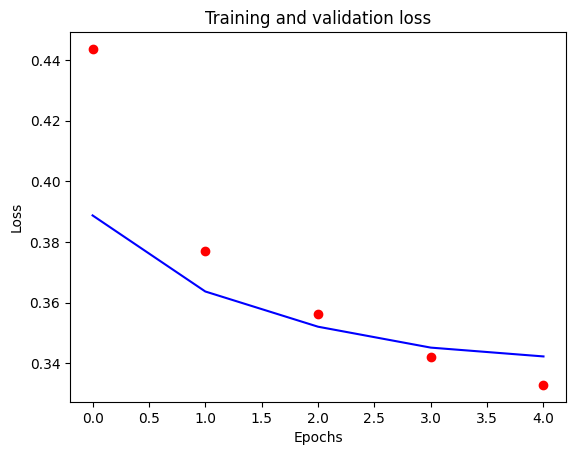

<Figure size 640x480 with 0 Axes>

In [45]:
acc = CNN_model_4_history['accuracy']
val_acc = CNN_model_4_history['val_accuracy']
loss = CNN_model_4_history['loss']
val_loss = CNN_model_4_history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()

In [46]:
CNN_model_5.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_7            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_12 (Embedding)        │ (None, 100, 64)        │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 100, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 100, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 100, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,573 (1.49 MB)

 Trainable params: 129,857 (507.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 259,716 (1014.52 KB)

<Figure size 640x480 with 0 Axes>

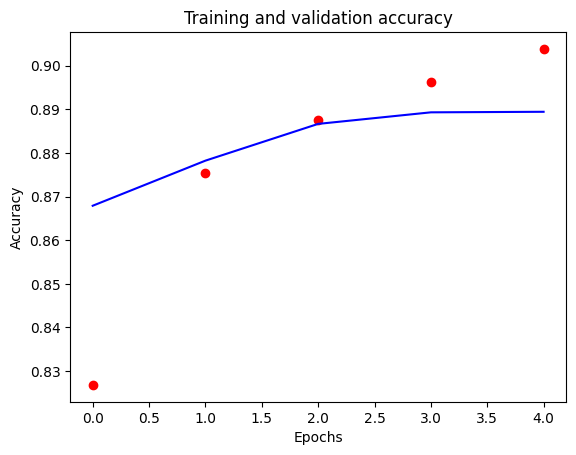

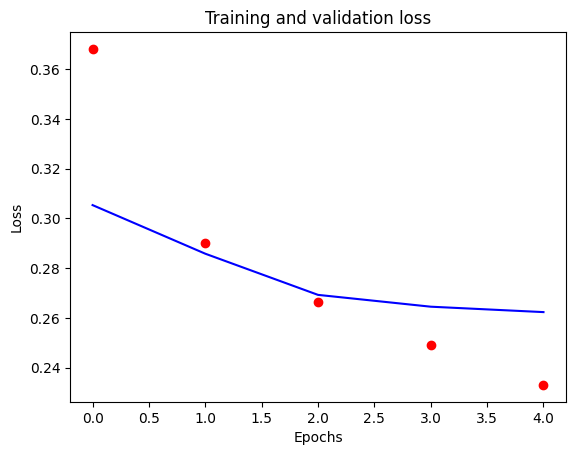

<Figure size 640x480 with 0 Axes>

In [47]:
acc = CNN_model_5_history['accuracy']
val_acc = CNN_model_5_history['val_accuracy']
loss = CNN_model_5_history['loss']
val_loss = CNN_model_5_history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()

## Evaluate the trained models on the test data

In [48]:
# put your code here
# Evaluate CNN_model_4
CNN_model_4.evaluate(test_data, return_dict=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8474 - loss: 0.3451


{'accuracy': 0.8474718928337097, 'loss': 0.3446425795555115}

In [49]:
# Evaluate CNN_model_5
CNN_model_5.evaluate(test_data, return_dict=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8885 - loss: 0.2648


{'accuracy': 0.8881843686103821, 'loss': 0.26533567905426025}

## Compare and comment on the results


>
> The changes I made for CNN_model_4 were increasing the word embedding length to 64 and I added two extra convolution layers, each with 64 filters and a kernel size of 3. This was to enable the model to capture more information. I did not increase the number of filters in my final solution as, during testing,  this seemed to not only make a small difference to the results, but also started to show slight signs of over-fitting.
> 
> Finally, I added a dropout layer, as without it, the training and validation graphs were starting to show very slight signs of over-fitting. As the signs were small, I chose a small rate of dropout (0.1) to only reduce the complexity slightly.
>
> The results were as intended. The accuracy increased from 0.83 to 0.85 and the loss decreased from 0.38 to 0.34.
>
> For CNN_model_5, I made two changes. The first change was to increase the vocab length from 300 to 1000. This would reduce the number of OOV words the model would encounter and would give the model better understanding and in theory, should improve the model.
> 
> The second change I made was to increase the size of the kernel in all three of the CNN layers from 3 to 5. This was so the model could capture more information.
> 
> The results was as expected. The accuracy increased from 0.85 to 0.89 and the loss decreased from 0.35 to 0.27.
> 
> This was increase in performance from CNN_model_4 to CNN_model_5 was far greater than from CNN_model_3 to CNN_model_4. This suggests the large increase in the vocab size, was the most significant factor in bettering the model.
>
> While increasing the kernel size did also help the improvements, we know it would not have been as drastic an improvement due to the results from CNN_model_2 to CNN_model_3, where the kernel size is reduced.
>
> These results mean that CNN_model_5 is both the most accurate model and the model with the least loss. Making it the best model we have tested so far. 

## Create the further improved models

In [54]:
KERNEL_SIZE_3=3
EMBEDDING_LEN=64

combined_model_4 = Sequential([
    encoder300,
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE_3, padding='same', activation='relu'),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE_3, padding='same', activation='relu'),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE_3, padding='same', activation='relu'),
    Dropout(rate=0.1),
    MaxPooling1D(pool_size=2),
    Dense(64, activation='relu'),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

In [55]:
# Increase vocab size
encoder1000 = tf.keras.layers.TextVectorization(output_sequence_length=100,max_tokens=1000)
encoder1000.load_assets('encoder1000')

KERNEL_SIZE_5 = 5
EMBEDDING_LEN = 64

combined_model_5= Sequential([
    encoder1000,
    Embedding(input_dim=len(encoder1000.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE_5, padding='same', activation='relu'),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE_5, padding='same', activation='relu'),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE_5, padding='same', activation='relu'),
    Dropout(rate=0.4),
    MaxPooling1D(pool_size=2),
    Dense(64, activation='relu'),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

## Train the models, show a summary of each model's structure and parameters, and produce training and validation curves

In [56]:
combined_model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# Train model
combined_model_4_history = combined_model_4.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d_27' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.7219 - loss: 0.5168 - val_accuracy: 0.8222 - val_loss: 0.3893
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8327 - loss: 0.3734 - val_accuracy: 0.8426 - val_loss: 0.3537
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8456 - loss: 0.3491 - val_accuracy: 0.8493 - val_loss: 0.3389
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8553 - loss: 0.3320 - val_accuracy: 0.8529 - val_loss: 0.3332
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8619 - loss: 0.3195 - val_accuracy: 0.8556 - val_loss: 0.3299


In [57]:
# Save the trained models and training history

# save combined_model_4
combined_model_4.save('combined_model_4_review.keras')
with open('combined_model_4_review_history.json', 'w') as f:
    json.dump(combined_model_4_history.history, f)

In [58]:
# Reload the models and training data
# combined_model_4
combined_model_4 = tf.keras.models.load_model('combined_model_4_review.keras')
with open('combined_model_4_review_history.json') as f:
    combined_model_4_history = json.load(f)


In [59]:
combined_model_4.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 100, 64)        │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 100, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 100, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 100, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 50, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 478,085 (1.82 MB)

 Trainable params: 159,361 (622.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 318,724 (1.22 MB)

<Figure size 640x480 with 0 Axes>

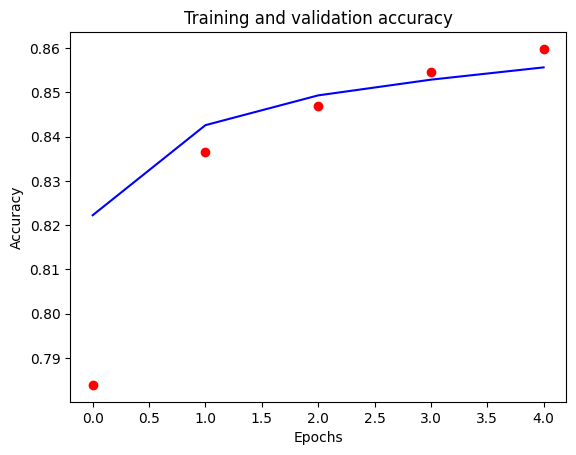

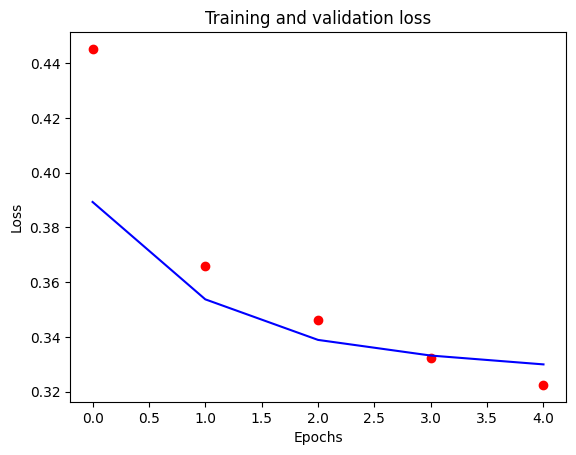

<Figure size 640x480 with 0 Axes>

In [60]:
acc = combined_model_4_history['accuracy']
val_acc = combined_model_4_history['val_accuracy']
loss = combined_model_4_history['loss']
val_loss = combined_model_4_history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()

In [61]:
# Compile model combined_model_5
combined_model_5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# Train model combined_model_5
combined_model_5_history = combined_model_5.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d_30' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7431 - loss: 0.4783 - val_accuracy: 0.8716 - val_loss: 0.3058
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.8789 - loss: 0.2875 - val_accuracy: 0.8825 - val_loss: 0.2806
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8935 - loss: 0.2577 - val_accuracy: 0.8895 - val_loss: 0.2649
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9047 - loss: 0.2363 - val_accuracy: 0.8910 - val_loss: 0.2636
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9116 - loss: 0.2215 - val_accuracy: 0.8922 - val_loss: 0.2585


In [62]:
# Save the trained models and training history
# combined_model_5
combined_model_5.save('combined_model_5_review.keras')
with open('combined_model_5_review_history.json', 'w') as f:
    json.dump(combined_model_5_history.history, f)

In [63]:
# combined_model_5
combined_model_5 = tf.keras.models.load_model('combined_model_5_review.keras')
with open('combined_model_5_review_history.json') as f:
    combined_model_5_history = json.load(f)

In [64]:
combined_model_5.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_11           │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, 100, 64)        │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 100, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 100, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 100, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 50, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 686,213 (2.62 MB)

 Trainable params: 228,737 (893.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 457,476 (1.75 MB)

<Figure size 640x480 with 0 Axes>

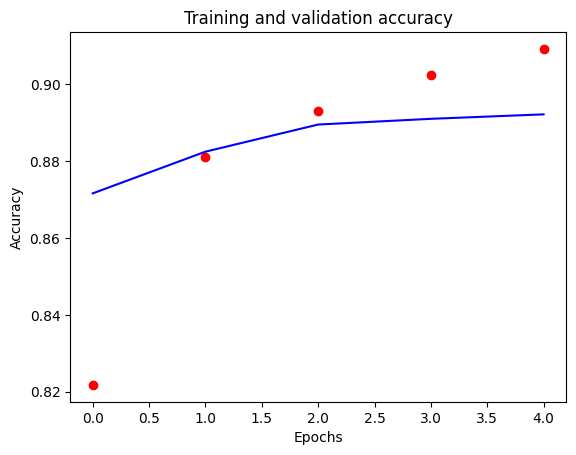

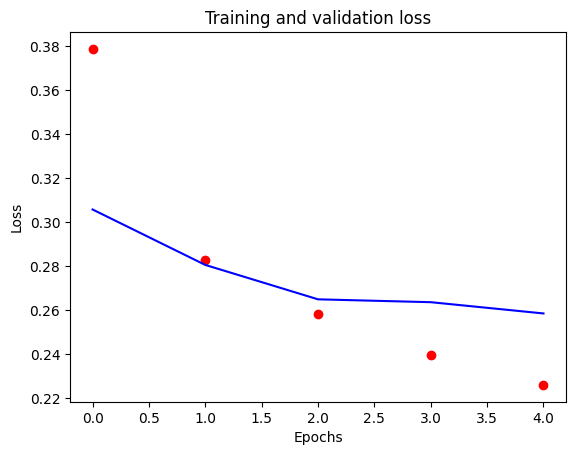

<Figure size 640x480 with 0 Axes>

In [65]:
acc = combined_model_5_history['accuracy']
val_acc = combined_model_5_history['val_accuracy']
loss = combined_model_5_history['loss']
val_loss = combined_model_5_history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()

## Evaluate the trained models on the test data

In [68]:
combined_model_4.evaluate(test_data, return_dict=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8552 - loss: 0.3314


{'accuracy': 0.8548156023025513, 'loss': 0.3316890299320221}

In [67]:
combined_model_5.evaluate(test_data, return_dict=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8902 - loss: 0.2617


{'accuracy': 0.8910156488418579, 'loss': 0.26103463768959045}

## Compare and comment on the results


>
> Combining CNNs and LSTMs should lead to better results. This is because the CNN layers will learn the spatial structure from the input data and then these learned features will be put through the LSTM units where it will handle the temporal trends and be learned as sequences. These methods are often combined when dealing with time-series data.
>
> By adding LSTM units to both CNN_model_4 and CNN_model_5, I expected a noticeable increase in the accuracy and decrease in the loss. I had also hoped this would be the case, as combining CNN and LSTM layers would no doubt increase the number of parameters, which, without improving the models accuracy or loss, would mean the model has gotten worse.
>
> I added 128 LSTM units to my CNN_model_4. I thought this would be enough for the sequences to be learned from the spatial structures fed into the units from the CNN. My results were underwhelming. With an increase in 0.01, from 0.84 to 0.85 in the accuracy. The loss also shared a similar improvement, with the loss decreasing 0.01, from 0.34 to 0.33. While this is a small increase, my fear about the number of parameters was true, the new model used 478,085, which is significantly higher than 181,445 parameters for my CNN_model_4. This is a huge increase in computational resources for such a small increase in performance by the model. This would perhaps be acceptable in model mission critical applications where the failure of the outcome can be catastrophic.
>
> My combined version of my CNN_model_5 showed similar, if not slightly worse results. I again added 128 LSTM units and saw an increase in the accuracy of less than 0.01. from 0.888 to 0.891. The loss also decreased minimally from 0.265 to 0.261. In testing, the model also started to show signs of over-fitting. I increased the dropout rate from 0.1 to 0.5. At 0.1, the accuracy of the model decreased to 0.87 and the loss increased to 0.28. This would have been a result of the added complexity and specificity of the 1000 word vocab being used on the training data. I corrected this by increasing the dropout rate. The graphs still show very moderate signs that the model might be starting to over-fit, but this is significantly less than with the lower dropout rate.
>
> While both models show is a small improvement, my fear about the number of parameters was true. The first new models used 478,085, which is significantly higher than 181,445 parameters for my CNN_model_4 and the second models used 686,213 parameters, another massive increase from its CNN counterpart of 389,573 parameters. This is a huge increase in computational resources for such a small increase in performance by the model. This would perhaps be acceptable in model mission critical applications where the failure of the outcome can be catastrophic. However for this application, it does not seem necessary.
>
> The reason these results may have come about is due to the training data. If spatial features are far more important here, the CNNs will be sufficient in learning from the data. This shows that this model does not need to rely on any long-term dependencies to extract the required information from the data in order to make accurate predictions.
>
> As a result of these findings, I believe the CNN models to be more suitable than the CNN-LSTM combined models. This is because they yielded such similar results, while the CNN only models used significantly less resources to achieve those results.
>  
